In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[100], [100] * 2, [100] * 3, [200], [200]*2,[200]*3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=200,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
            scheduler_patience=20,
        )

#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 756/756 [00:31<00:00, 24.16it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.38363153,
 'train_acc': 0.6930692791938782,
 'val_acc': 0.5581393837928772,
 'epoch': 150,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_150',
 'train_rmse': 0.6674912392349772,
 'val_rmse': 0.8490761052804039,
 'test_rmse': 0.9770442081172093,
 'train_rmse_perc': 0.16751768,
 'val_rmse_perc': 0.20270288,
 'test_rmse_perc': 0.24303669,
 'train_mae_perc': 0.12591091,
 'val_mae_perc': 0.15341279,
 'test_mae_perc': 0.1757324,
 'train_mcc': 0.5850807295760538,
 'val_mcc': 0.4036248080231799,
 'test_mcc': 0.38131828754199387,
 'test_acc': 0.532307

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200, 200],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.37834612,
 'train_acc': 0.6336632966995239,
 'val_acc': 0.48837196826934814,
 'epoch': 90,
 'model_class': 'fnn',
 'path_name': '4_[200_200_200]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_90',
 'train_rmse': 0.6674912392349772,
 'val_rmse': 0.8490761052804039,
 'test_rmse': 1.025445494182144,
 'train_rmse_perc': 0.16756022,
 'val_rmse_perc': 0.1896973,
 'test_rmse_perc': 0.26200074,
 'train_mae_perc': 0.13134575,
 'val_mae_perc': 0.14762878,
 'test_mae_perc': 0.19046584,
 'train_mcc': 0.5034263508842297,
 'val_mcc': 0.3103352115031736,
 'test_mcc': 0.30273691655149076,
 'test_acc': 0.47307690

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.38429305,
 'train_acc': 0.6534652709960938,
 'val_acc': 0.5348835587501526,
 'epoch': 120,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_120',
 'train_rmse': 0.674867056948593,
 'val_rmse': 0.8626621856275073,
 'test_rmse': 0.9801883649427955,
 'train_rmse_perc': 0.16780248,
 'val_rmse_perc': 0.20036928,
 'test_rmse_perc': 0.24161984,
 'train_mae_perc': 0.12773332,
 'val_mae_perc': 0.15375899,
 'test_mae_perc': 0.17548916,
 'train_mcc': 0.5300446722469948,
 'val_mcc': 0.3727442338556764,
 'test_mcc': 0.36357361893872503,
 'test_acc': 0.518461

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 756/756 [00:00<00:00, 30284.07it/s]


In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(325)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

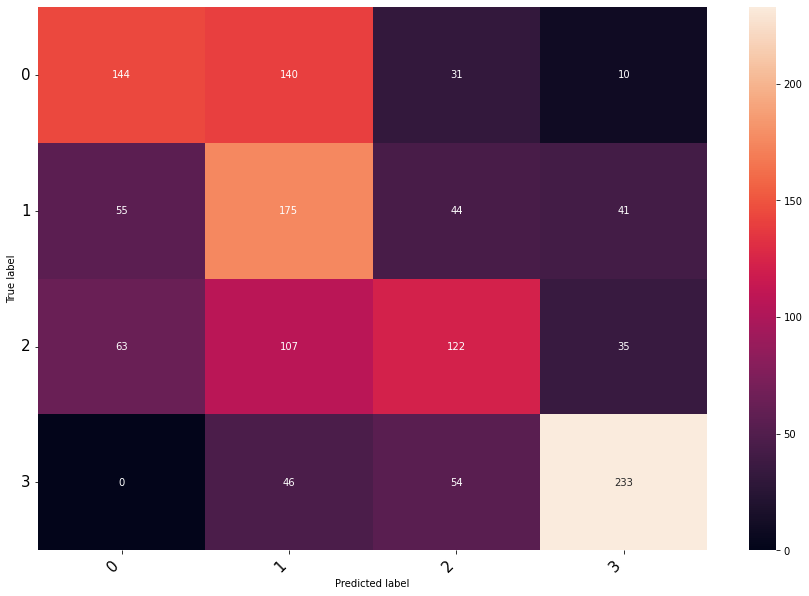

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.4431, 0.5556, 0.3731, 0.6997])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.23365606, 0.2557072, 0.271373, 0.2011436]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.15921813, 0.1979055, 0.21043286, 0.13585055]

### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

In [ ]:
res_edges = res_edges_gcn
res_edges[0]

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [20]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features=[[200]*2, [500]*2],
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=1000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=100,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            scheduler_patience=500,
        )

#### Results

In [22]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 22/22 [00:05<00:00,  3.71it/s]


True

In [23]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [200, 200],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 500,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.07001582,
 'train_acc': 0.9405940175056458,
 'val_acc': 0.5813952088356018,
 'epoch': 500,
 'model_class': 'sage',
 'path_name': '4_[200_200]_1_lstm_none_gn_ReLU()_0.0_0.01_adamw_max_val_mcc_True_mse_500_True_0_500',
 'train_rmse': 0.29851115706299675,
 'val_rmse': 0.9523532664857335,
 'test_rmse': 1.2727922061357855,
 'train_rmse_perc': 0.11727952,
 'val_rmse_perc': 0.277961,
 'test_rmse_perc': 0.33353457,
 'train_mae_perc': 0.09377543,
 'val_mae_perc': 0.2010494,
 'test_mae_perc': 0.24250916,
 'train_mcc': 0.9218844566506995,
 'val_mcc': 0.44294854851073234,


In [24]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 500,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.38177648,
 'train_acc': 0.6336632966995239,
 'val_acc': 0.46511614322662354,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0.0_0.01_adamw_max_val_mcc_True_mse_500_True_0_100',
 'train_rmse': 0.6052574936862545,
 'val_rmse': 0.8212299340934686,
 'test_rmse': 1.096147098494751,
 'train_rmse_perc': 0.15741302,
 'val_rmse_perc': 0.20223497,
 'test_rmse_perc': 0.27678075,
 'train_mae_perc': 0.122464545,
 'val_mae_perc': 0.15915538,
 'test_mae_perc': 0.2146437,
 'train_mcc': 0.5069667072309265,
 'val_mcc': 0.27600814078055685

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 500,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.38177648,
 'train_acc': 0.6336632966995239,
 'val_acc': 0.46511614322662354,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0.0_0.01_adamw_max_val_mcc_True_mse_500_True_0_100',
 'train_rmse': 0.6052574936862545,
 'val_rmse': 0.8212299340934686,
 'test_rmse': 1.096147098494751,
 'train_rmse_perc': 0.15741302,
 'val_rmse_perc': 0.20223497,
 'test_rmse_perc': 0.27678075,
 'train_mae_perc': 0.122464545,
 'val_mae_perc': 0.15915538,
 'test_mae_perc': 0.2146437,
 'train_mcc': 0.5069667072309265,
 'val_mcc': 0.27600814078055685

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 22/22 [00:00<00:00, 22048.91it/s]


#### cm

In [27]:
cm = all[sort_idx[0]]['test_cm'][0]

In [28]:
(cm.labels==0).sum()

tensor(325)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

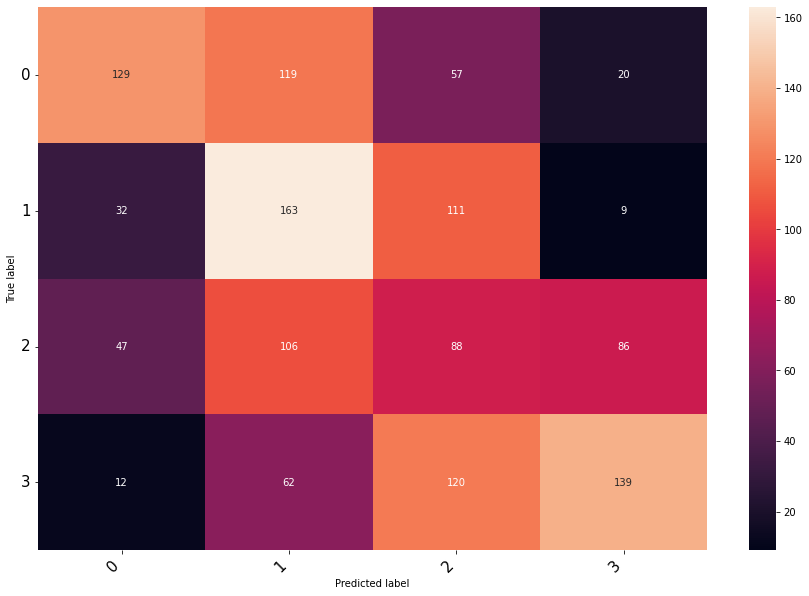

In [29]:
cm.visualize()

In [30]:
cm.class_accuracy

tensor([0.3969, 0.5175, 0.2691, 0.4174])

In [31]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.31253928, 0.2204688, 0.26573637, 0.29734153]

In [32]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.23453966, 0.17436892, 0.21639529, 0.23160347]

#### GraphSAGE Base_n

In [33]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [34]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

##### Results

In [35]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 2772/2772 [04:50<00:00,  9.53it/s]


True

In [36]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.6313561,
 'train_acc': 0.5445544123649597,
 'val_acc': 0.3953487277030945,
 'epoch': 80,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_right_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_80',
 'train_rmse': 0.9950371902099892,
 'val_rmse': 1.2482545953785713,
 'test_rmse': 1.3825839799225441,
 'train_rmse_perc': 0.24421328,
 'val_rmse_perc': 0.2866674,
 'test_rmse_perc': 0.3376542,
 'train_mae_perc': 0.18582739,
 'val_mae_perc': 0.22649065,
 'test_mae_perc': 0.27210695,
 'train_mcc': 0.4047692577470886,
 'val_mcc': 0.17006024904030084,
 'te

In [37]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.1616507,
 'train_acc': 0.3465346395969391,
 'val_acc': 0.32558131217956543,
 'epoch': 70,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_70',
 'train_rmse': 1.0900086292691393,
 'val_rmse': 1.1411948043149114,
 'test_rmse': 1.2319465522871955,
 'train_rmse_perc': 0.26880473,
 'val_rmse_perc': 0.25392535,
 'test_rmse_perc': 0.2967625,
 'train_mae_perc': 0.22748059,
 'val_mae_perc': 0.2133988,
 'test_mae_perc': 0.25481245,
 'train_mcc': 0.12464108806970921,
 'val_mcc': 0.02614018052540714,
 'test_mcc'

In [38]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.0688442,
 'train_acc': 0.3465346395969391,
 'val_acc': 0.32558131217956543,
 'epoch': 20,
 'model_class': 'sage',
 'path_name': '4_[15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_20',
 'train_rmse': 1.0483367307263918,
 'val_rmse': 1.0454775252553032,
 'test_rmse': 1.2003204700284131,
 'train_rmse_perc': 0.25697494,
 'val_rmse_perc': 0.2600622,
 'test_rmse_perc': 0.2906916,
 'train_mae_perc': 0.21639308,
 'val_mae_perc': 0.22653465,
 'test_mae_perc': 0.25437242,
 'train_mcc': 0.09031003383089314,
 'val_mcc': 0.03843728589290225,
 'test_mcc'

In [39]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2772/2772 [00:00<00:00, 28944.17it/s]


##### cm

In [40]:
cm = all[sort_idx[0]]['test_cm'][0]

In [41]:
(cm.labels==0).sum()

tensor(325)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

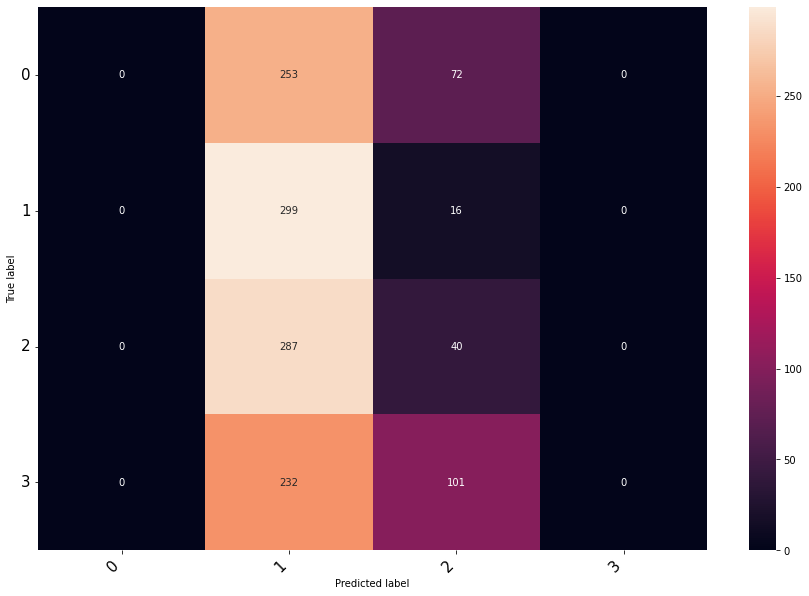

In [42]:
cm.visualize()

In [43]:
cm.class_accuracy

tensor([0.0000, 0.9492, 0.1223, 0.0000])

In [44]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.32735512, 0.10461619, 0.21273632, 0.4129225]

In [45]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.31946313, 0.08522764, 0.19850332, 0.40570974]

### GAT

In [46]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [47]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [48]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 6336/6336 [04:55<00:00, 21.46it/s]


In [49]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': None,
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 2.480289,
 'train_acc': 0.29702967405319214,
 'val_acc': 0.2790696918964386,
 'epoch': 99,
 'model_class': 'gat',
 'path_name': '4_[15_15]_1_[2_2]_None_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0',
 'train_rmse': 1.6167440694614017,
 'val_rmse': 1.7652985780789159,
 'test_rmse': 1.7220292144399338,
 'train_rmse_perc': 0.5045486,
 'val_rmse_perc': 0.54749537,
 'test_rmse_perc': 0.53447014,
 'train_mae_perc': 0.43059403,
 'val_mae_perc': 0.47930235,
 'test_mae_perc': 0.45101535,
 'train_mcc': 0.1177403157583978,

In [50]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.0231202,
 'train_acc': 0.31683164834976196,
 'val_acc': 0.3023254871368408,
 'epoch': 20,
 'model_class': 'gat',
 'path_name': '4_[15]_1_[4_4]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_20',
 'train_rmse': 1.0762972830887192,
 'val_rmse': 1.0890576254854043,
 'test_rmse': 1.1681675327689023,
 'train_rmse_perc': 0.26326352,
 'val_rmse_perc': 0.24632362,
 'test_rmse_perc': 0.29035795,
 'train_mae_perc': 0.22102757,
 'val_mae_perc': 0.21228358,
 'test_mae_perc': 0.24885987,
 'train_mcc': 0.03878845624667849,


In [51]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.0924826,
 'train_acc': 0.30693066120147705,
 'val_acc': 0.2558138966560364,
 'epoch': 10,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[2_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_10',
 'train_rmse': 1.024453488692898,
 'val_rmse': 1.1713637450663281,
 'test_rmse': 1.1327298544123057,
 'train_rmse_perc': 0.26708668,
 'val_rmse_perc': 0.26092812,
 'test_rmse_perc': 0.2877151,
 'train_mae_perc': 0.22415887,
 'val_mae_perc': 0.22306514,
 'test_mae_perc': 0.25037324,
 'train_mcc': 0.034687061832069814,
 'v

In [52]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6336/6336 [00:00<00:00, 22528.25it/s]
